In [1]:
import itertools

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:

torch.cuda.get_device_name(0)

'Tesla K80'

In [3]:
# prepare batch_loader 
batch_size=64
trn_dataset = datasets.MNIST('../mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor
                                 transforms.Normalize((0.1307,), (0.3081,)) # image, label
                             ])) 

trn_loader = torch.utils.data.DataLoader(trn_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

In [4]:
val_dataset = datasets.MNIST("../mnist_data/", 
                             download=False,
                             train=False,
                             transform= transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307, ),(0.3081, ))
                           ]))

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

In [5]:
num_batches = len(trn_loader)

In [6]:
data = next(iter(trn_loader))

In [7]:
img, label = data

In [8]:
img.size() # batch_size, num_channel, x, y

torch.Size([64, 1, 28, 28])

In [9]:
label.size() # 0~9까지의 숫자가 batch_size 만큼

torch.Size([64])

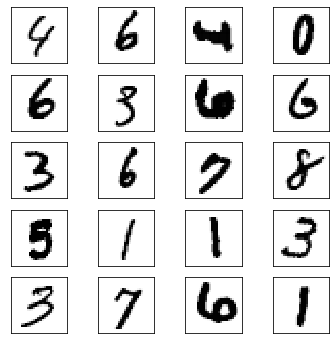

In [10]:
# create figure for plotting
row_num = 5
col_num = 4
fig, ax = plt.subplots(row_num, col_num, figsize=(6,6))
for i, j in itertools.product(range(row_num), range(col_num)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
    
for k in range(row_num*col_num):
    i = k//col_num
    j = k%col_num
    ax[i,j].cla() # clear the current axis
    ax[i,j].imshow(img[k,:].data.cpu().numpy().reshape(28,28), cmap='Greys')

In [17]:
img[1,:].data.cpu().numpy().reshape(28,28)

array([[-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.4242

In [11]:
Image(url= "https://9bow.github.io/PyTorch-tutorials-kr/_images/mnist.png")

In [12]:
# construct model on cuda if available

use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(1, 6, 5, 1) # 6@24*24
        # activation ReLU
        pool1 = nn.MaxPool2d(2) # 6@12*12
        conv2 = nn.Conv2d(6, 16, 5, 1) # 16@8*8
        # activation ReLU
        pool2 = nn.MaxPool2d(2) # 16@4*4
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(16*4*4, 120)
        # activation ReLU
        fc2 = nn.Linear(120, 84)
        # activation ReLU
        fc3 = nn.Linear(84, 10)

        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        # gpu로 할당
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) # @16*4*4
        # make linear
        dim = 1
        for d in out.size()[1:]: #16, 4, 4
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [13]:
cnn = CNNClassifier()

In [14]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

In [15]:
# hyper-parameters
num_epochs = 2

In [16]:
num_batches

938

In [17]:
batch_size

64

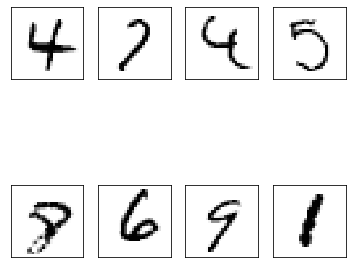

label: tensor([4, 7, 4, 5, 8, 6, 9, 1], device='cuda:0')
prediction: tensor([4, 7, 4, 5, 8, 6, 9, 1], device='cuda:0')
epoch: 2/2 | step: 900/938 | trn loss: 1.4913 | val loss: 1.4879


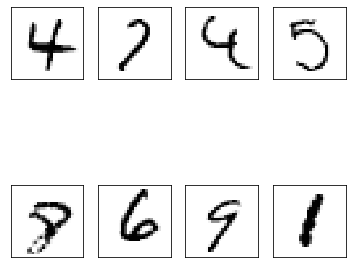

In [18]:
# create figure for plotting
row_num = 2
col_num = 4
fig, ax = plt.subplots(row_num, col_num, figsize=(6,6))
for i, j in itertools.product(range(row_num), range(col_num)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False) 
    
trn_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    trn_loss = 0.0
    for i, data in enumerate(trn_loader):
        x, label = data
        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = cnn(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        
        # 학습과정 출력
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(val_loader):
                    val_x, val_label = val
                    if use_cuda:
                        val_x = val_x.cuda()
                        val_label =val_label.cuda()
                    val_output = cnn(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss

            # draw last val dataset
            for k in range(row_num*col_num):
                ii = k//col_num
                jj = k%col_num
                ax[ii,jj].cla() # clear the current axis
                ax[ii,jj].imshow(val_x[k,:].data.cpu().numpy().reshape(28,28), cmap='Greys')
            
            display.clear_output(wait=True)
            display.display(plt.gcf()) # get a reference to a current figure
                
            print("label: {}".format(val_label[:row_num*col_num]))
            print("prediction: {}".format(val_output.argmax(dim=1)[:row_num*col_num]))
            del val_output
            del v_loss
            
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader)
            ))            
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(val_loader))
            trn_loss = 0.0

Text(0, 0.5, 'loss')

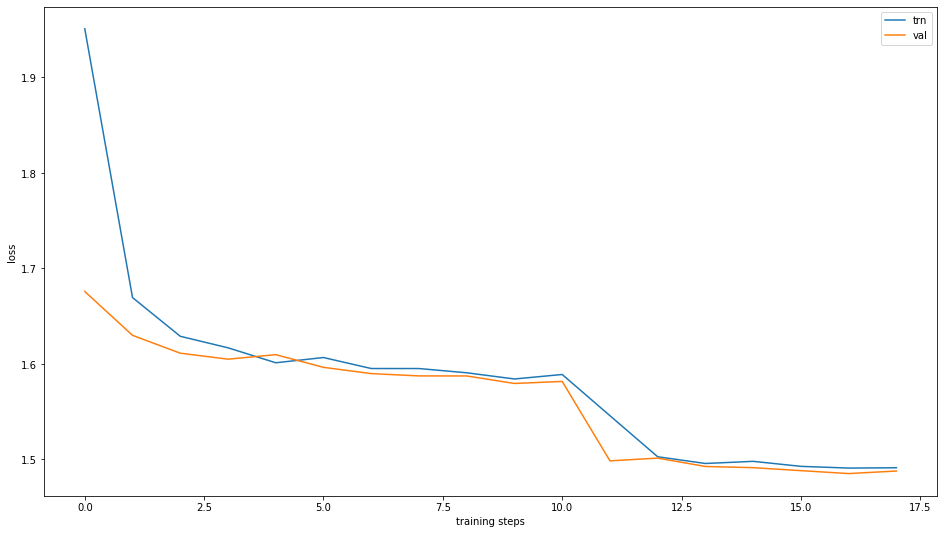

In [19]:
plt.figure(figsize=(16,9))
x_range = range(len(trn_loss_list))
plt.plot(x_range, trn_loss_list, label="trn")
plt.plot(x_range, val_loss_list, label="val")
plt.legend()
plt.xlabel("training steps")
plt.ylabel("loss")

In [20]:
# val acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(val_loader):
        val_x, val_label = val
        if use_cuda:
            val_x = val_x.cuda()
            val_label =val_label.cuda()
        val_output = cnn(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("acc: {:.2f}".format(corr_num / total_num * 100))

acc: 97.69
